# Transformer Model Medium Size

Trained with Google TPU v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# write where you want to save all your files
root = "/content/drive/MyDrive/Franklin_JacobsonGoogleDrive/ActigraphyTransformer/Modeling/Class Benzos/Smoothed Data/[Smoothed]Transformer_Medium"

n_layers = 2
patch_length = 18

# Imports and **Connect To TPU**

In [ ]:
!pip install pyarrow fastparquet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.4 MB/s eta 0:00:00


In [ ]:
# @title Importing

# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import os
from IPython.display import clear_output

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
#from keras.layers.embeddings import Embedding
from keras.metrics import AUC

# Tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random

In [ ]:
## SEEDS

# Hard Code Random Seeds.
r1 = 0
r2 = 1

# Set Random Seed
random.seed(r1)
tf.random.set_seed(r2)

In [ ]:
#@title Connect to TPU
print("TensorFlow version:", tf.__version__)

# Connect to the TPU cluster or fall back to CPU/GPU
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Tries to connect to the TPU
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
  devices = tf.config.list_logical_devices('TPU')
  print('TPU devices:', devices)
except ValueError:
  print("Could not connect to TPU; using CPU/GPU strategy instead.")
  strategy = tf.distribute.get_strategy()

# Example computation using the strategy
with strategy.scope():
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

  @tf.function
  def matmul_fn(x, y):
    return tf.matmul(x, y)

  z = strategy.run(matmul_fn, args=(a, b))

print(z)

TensorFlow version: 2.15.0
TPU devices: [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
PerReplica:{
  0: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  1: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  2: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  3: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  4: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  5: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  6: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32),
  7: tf.

# Prepare Data

Might need this

In [ ]:
# !pip install pyarrow fastparquet

In [ ]:
import pandas as pd
data_all = pd.read_parquet('/content/drive/MyDrive/Franklin_JacobsonGoogleDrive/ActigraphyTransformer/Data/Actigraphy/[smoothed]WideSeqnActi_AndMeds_ALL.parq')

# Choose Variable

In [ ]:
# Spit actigraphy X and then y
chosen_y = data_all['Taking_Benzodiazepine']
chosen_X = data_all.drop(columns=['Taking_SSRI', 'Taking_Benzodiazepine', 'Taking_Psychotropic'])

Make X

In [ ]:
# Load Data X -------
Wide_X = chosen_X
data_wide = Wide_X

# Standard Scalar
scaler = StandardScaler()
scaler.fit(data_wide)
data_wide = scaler.transform(data_wide)

# Convert DF to array
data_wide = np.array(data_wide)

Make Y

In [ ]:
# Load Data Y
Y = chosen_y

# Make y array as well
y = np.hstack(np.asarray(Y)).reshape(len(Y),1)

# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

# First, split into train and temp (this temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(data_wide, y, test_size=0.2, stratify=y, random_state=19)

# Now, split the temp data into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=19)  # Splitting the temp equally

# Reshape Train, Validation and Test
n_participants_train = X_train.shape[0]
n_participants_val = X_val.shape[0]
n_participants_test = X_test.shape[0]
n_timesteps = X_train.shape[1]
n_features = 1

# Reshape data
X_train = X_train.reshape((n_participants_train, n_timesteps, n_features))
X_val = X_val.reshape((n_participants_val, n_timesteps, n_features))
X_test = X_test.reshape((n_participants_test, n_timesteps, n_features))

Basic Data Analysis

In [ ]:
# Shape Analysis
print("shape of X:", data_wide.shape)
print("shape of y:", y.shape)
# Class Analysis
benzoUse = int(sum(y))
total = int(len(y))
benzoNoUse = int(total-benzoUse)

print("Benzo Use:", benzoUse, "participants")
print("Benzo No Use:", benzoNoUse, "participants")

shape of X: (29307, 10080)
shape of y: (29307, 1)
Benzo Use: 694 participants
Benzo No Use: 28613 participants


<ipython-input-14-9e0b4d46660a>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  benzoUse = int(sum(y))


# MODELING

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the Transformer block
def TransformerBlock(embed_dim, num_heads, ff_dim, rate=0.1):
    input_layer = tf.keras.layers.Input(shape=(None, embed_dim))
    attention_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    attention_output, attention_weights = attention_layer(input_layer, input_layer, return_attention_scores=True)
    attention_output = tf.keras.layers.Dropout(rate)(attention_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(input_layer + attention_output)
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(out1)
    ff_output = tf.keras.layers.Dense(embed_dim)(ff_output)
    ff_output = tf.keras.layers.Dropout(rate)(ff_output)
    final_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ff_output)
    return tf.keras.Model(inputs=input_layer, outputs=[final_output, attention_weights])

# Define the main model
def create_model(input_size=10080, patch_size=patch_length, embed_dim=96, num_heads=12, ff_dim=256, num_layers=n_layers, rate=0.1, training=True):
    num_patches = input_size // patch_size
    inputs = tf.keras.layers.Input(shape=(input_size,))

    reshaped = tf.keras.layers.Reshape((num_patches, patch_size))(inputs)
    patch_embeddings = tf.keras.layers.Dense(embed_dim)(reshaped)

    positional_emb = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(tf.range(num_patches))
    x = patch_embeddings + positional_emb

    attention_weights = []

    for _ in range(num_layers):
        x, weights = TransformerBlock(embed_dim, num_heads, ff_dim, rate)(x)
        if not training:
            attention_weights.append(weights)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    if training:
        return tf.keras.Model(inputs=inputs, outputs=outputs)
    else:
        return tf.keras.Model(inputs=inputs, outputs=[outputs] + attention_weights)



# Training & Evaluation

In [ ]:
# Params ----------
# Balance Weights
class_weights = {0: (benzoUse/total),  # Custom Setting Class Weights
                1: (benzoNoUse/total)}

# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                            patience=250,
                                            restore_best_weights=True,
                                            )

In [ ]:
# Compile the model -----
with strategy.scope():
  train_model = create_model(training=True)
  train_model.compile(
    # Metrics
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= tf.keras.metrics.AUC(name='auc'),
    # Optimizer
    optimizer= tf.keras.optimizers.Adam(
      learning_rate=0.00001,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False
))

train_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10080)]           0         
                                                                 
 reshape (Reshape)           (None, 560, 18)           0         
                                                                 
 dense (Dense)               (None, 560, 96)           1824      
                                                                 
 tf.__operators__.add (TFOp  (None, 560, 96)           0         
 Lambda)                                                         
                                                                 
 model (Functional)          [(None, None, 96),        495808    
                              (None, 12, None, None)             
                             ]                                   
                                                           

In [ ]:
# Train the Model -----
history = train_model.fit(
      X_train, y_train,
      epochs= 5000,
      batch_size= 64,
      validation_data = (X_val, y_val),
      shuffle=False,
      class_weight=class_weights,
      callbacks = [callback],
      verbose = 2)

Epoch 1/5000
367/367 - 33s - loss: 0.0321 - auc: 0.5732 - val_loss: 0.8334 - val_auc: 0.6015 - 33s/epoch - 90ms/step
Epoch 2/5000
367/367 - 11s - loss: 0.0313 - auc: 0.6019 - val_loss: 0.7918 - val_auc: 0.5984 - 11s/epoch - 30ms/step
Epoch 3/5000
367/367 - 11s - loss: 0.0310 - auc: 0.6152 - val_loss: 0.8058 - val_auc: 0.5882 - 11s/epoch - 30ms/step
Epoch 4/5000
367/367 - 11s - loss: 0.0309 - auc: 0.6156 - val_loss: 0.7899 - val_auc: 0.6622 - 11s/epoch - 31ms/step
Epoch 5/5000
367/367 - 11s - loss: 0.0310 - auc: 0.6084 - val_loss: 0.7961 - val_auc: 0.6590 - 11s/epoch - 30ms/step
Epoch 6/5000
367/367 - 11s - loss: 0.0306 - auc: 0.6274 - val_loss: 0.7705 - val_auc: 0.6409 - 11s/epoch - 30ms/step
Epoch 7/5000
367/367 - 11s - loss: 0.0308 - auc: 0.6199 - val_loss: 0.7850 - val_auc: 0.6547 - 11s/epoch - 30ms/step
Epoch 8/5000
367/367 - 11s - loss: 0.0306 - auc: 0.6297 - val_loss: 0.7655 - val_auc: 0.6164 - 11s/epoch - 30ms/step
Epoch 9/5000
367/367 - 11s - loss: 0.0308 - auc: 0.6178 - val_lo

In [ ]:
# Save Model
train_model.save(root+'/my_model.h5')
train_model.save_weights(root+'/my_model_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Evaluate the model on the Validation Data
val_loss, val_auc = train_model.evaluate(X_val, y_val, verbose=2)

# Print the results
print("Val Loss:", val_loss)
print("Val AUC:", val_auc)
print(" ") # space

# Evaluate the model on the Test Data
test_loss, test_auc = train_model.evaluate(X_test, y_test, verbose=2)

# Print the results
print("Test Loss:", test_loss)
print("Test AUC:", test_auc)

92/92 - 5s - loss: 0.7519 - auc: 0.7040 - 5s/epoch - 53ms/step
Val Loss: 0.7519469857215881
Val AUC: 0.703961968421936
 
92/92 - 1s - loss: 0.7523 - auc: 0.7218 - 1s/epoch - 16ms/step
Test Loss: 0.7522586584091187
Test AUC: 0.7217706441879272


# Model Introspection

In [ ]:
# input the latest layer
layer_num = n_layers-1
patch_size = patch_length

#tester

In [ ]:
# Evaluation model with attention weights
with strategy.scope():
  eval_model = create_model(training=False)

In [ ]:
# @title Function 1
import matplotlib.pyplot as plt
import numpy as np

##### SQUARE PLOTTER -----------

def plot_average_attention_weights(attention_weights, layer_num):
    # Extract the weights for the specified layer
    layer_weights = attention_weights[layer_num]  # Shape: (batch_size, num_heads, seq_length, seq_length)

    # Compute the mean across all heads
    mean_weights = np.mean(layer_weights, axis=1)  # Mean over the head dimension, resulting in (batch_size, seq_length, seq_length)

    # Set the figure and specify its size
    fig, ax = plt.subplots(figsize=(7, 7))  # Adjust the figsize as needed to make the plot appear bigger

    # Plotting the mean attention weights for the first sample in the batch using 'bwr' colormap
    cax = ax.matshow(mean_weights[0], cmap='bwr')  # Index 0 for the first sample

    # Create a colorbar with a smaller size
    fig.colorbar(cax, fraction=0.046, pad=0.04)  # Adjust the fraction to make the colorbar thinner or thicker

    ax.set_title(f'Layer {layer_num+1} Mean Attention Weights Across All Heads')
    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
    plt.show()

In [ ]:
#@title Function 2

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def process_attention_weights(attention_weights, layer_num, patch_size):
    # Sum the attention weights across the key positions for each query position
    attention_profile = np.sum(attention_weights[layer_num][0], axis=1)

    # Average across heads
    attention_profile = np.mean(attention_profile, axis=0)

    # Normalize the attention profile to sum to 1
    attention_profile /= np.sum(attention_profile)

    # Expand the attention weights to match the original data's timeline
    expanded_attention_profile = np.repeat(attention_profile, patch_size)

    return expanded_attention_profile


def plot_data_with_attention_overlay_7d(original_data, attention_weights, layer_num, patch_size):
    # Process the attention weights
    processed_attention_profile = process_attention_weights(attention_weights, layer_num, patch_size)

    # Create a colormap based on the processed attention weights
    cmap = plt.cm.seismic
    norm = mcolors.Normalize(vmin=processed_attention_profile.min(), vmax=processed_attention_profile.max())

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # Plot the original data
    ax1.plot(original_data, label='Original Data', color='black')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Original Data Value', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Set up x-axis for daily ticks and labels
    days = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7']
    minutes_per_day = 1440
    week_minutes = minutes_per_day * len(days)
    day_starts = np.arange(0, week_minutes, minutes_per_day)
    ax1.set_xticks(day_starts)
    ax1.set_xticklabels(days, rotation=45)
    ax1.set_xlim([0, week_minutes])

    # Create a twin Axes sharing the x-axis to plot the attention weights
    ax2 = ax1.twinx()

    # Plot the attention as a background colormap
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    ax2.imshow([processed_attention_profile], aspect='auto', extent=[0, len(original_data), ax1.get_ylim()[0], ax1.get_ylim()[1]], cmap=cmap, norm=norm, alpha=0.3)
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    # Add a colorbar for the attention overlay
    cbar = plt.colorbar(sm, ax=ax2, pad=0.1, aspect=10)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15)

    fig.tight_layout()  # To ensure no overlap of y-ticks
    plt.show()


In [ ]:
#@title Function 3

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def process_attention_weights(attention_weights, layer_num, patch_size):
    # Sum the attention weights across the key positions for each query position
    attention_profile = np.sum(attention_weights[layer_num][0], axis=1)

    # Average across heads
    attention_profile = np.mean(attention_profile, axis=0)

    # Normalize the attention profile to sum to 1
    attention_profile /= np.sum(attention_profile)

    # Expand the attention weights to match the original data's timeline
    expanded_attention_profile = np.repeat(attention_profile, patch_size)

    return expanded_attention_profile

def downsample_to_daily(data, days=7, minutes_per_day=1440):
    # Reshape the data to (days, minutes_per_day)
    reshaped_data = data.reshape((days, minutes_per_day))
    # Calculate the mean across days for each minute
    daily_mean_data = reshaped_data.mean(axis=0)
    return daily_mean_data


def plot_data_with_attention_overlay_1day(original_data, attention_weights, layer_num, patch_size):
    # Process the attention weights
    processed_attention_profile = process_attention_weights(attention_weights, layer_num, patch_size)

    # Downsample both the original data and the attention profile to a daily scale
    daily_original_data = downsample_to_daily(original_data)
    daily_attention_profile = downsample_to_daily(processed_attention_profile)

    # Create a colormap based on the processed attention weights
    cmap = plt.cm.bwr
    norm = mcolors.Normalize(vmin=daily_attention_profile.min(), vmax=daily_attention_profile.max())

    fig, ax1 = plt.subplots(figsize=(12, 4))

    # Plot the downsampled original data
    ax1.plot(daily_original_data, label='Daily Mean Original Data', color='black')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Daily Mean Original Data Value', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Define custom tick positions and labels for hours
    hours = np.arange(0, 25, 3)  # Hours from 0 to 24
    minutes_per_hour = 60
    hour_positions = hours * minutes_per_hour
    hour_labels = [f'{hour:02d}:00' for hour in hours]
    ax1.set_xticks(hour_positions)
    ax1.set_xticklabels(hour_labels)

    # Create a twin Axes sharing the x-axis to plot the attention weights
    ax2 = ax1.twinx()

    # Plot the attention as a background colormap
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for older versions of matplotlib
    minutes_per_day = 1440
    ax2.imshow([daily_attention_profile], aspect='auto', extent=[0, minutes_per_day, ax1.get_ylim()[0], ax1.get_ylim()[1]], cmap=cmap, norm=norm, alpha=0.5)
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    # Add a colorbar for the attention overlay
    cbar = plt.colorbar(sm, ax=ax2, pad=0.1, aspect=10)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15)

    fig.tight_layout()  # To ensure no overlap of y-ticks

    plt.show()

AUC OVER EPOCHS

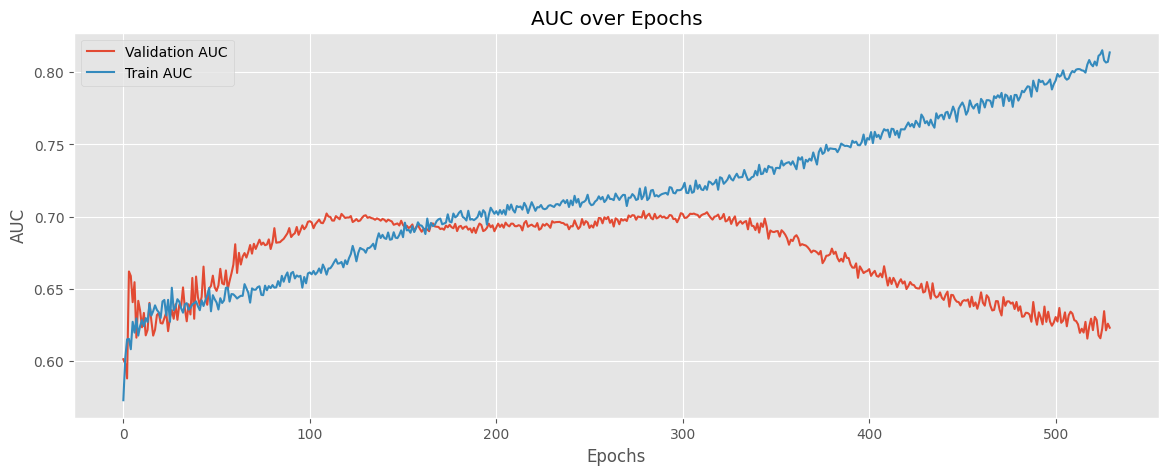

In [ ]:
# Style Sheet
plt.style.use('ggplot')

plt.figure(figsize=(14,5))
plt.title("AUC over Epochs")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.plot(history.history['auc'], label='Train AUC')
plt.legend()

ANALYZE SOME PARTICIPANTS

In [ ]:
# Plot for control patients
i = 0
total = 0
for participant in y_test:

  # only plot for 10 participants
  if i == 10:
    break

  # if they are in the control group
  if participant != 1:
    i+=1  #increase plotted number of participants
    # get the attention weights
    predictions, *att_weights = eval_model.predict(X_test[total:total+1])
    a = scaler.inverse_transform([X_test[total].reshape(10080,)]).reshape(10080,1)

    # Make All The PLOTS
    print("=====================================================")
    print("CONTROL PARTICIPANT: " + str(total+1))
    print("=====================================================")
    plot_average_attention_weights(att_weights,layer_num)
    plot_data_with_attention_overlay_7d(a, att_weights, layer_num, patch_size)
    plot_data_with_attention_overlay_1day(a, att_weights, layer_num, patch_size)
  total += 1



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Plot for control patients
i = 0
total = 0
for participant in y_test:

  # only plot for 10 participants
  if i == 10:
    break

  # if they are in the control group
  if participant == 1:
    i+=1  #increase plotted number of participants
    # get the attention weights
    predictions, *att_weights = eval_model.predict(X_test[total:total+1])
    a = scaler.inverse_transform([X_test[total].reshape(10080,)]).reshape(10080,1)

    # Make All The PLOTS
    print("=====================================================")
    print("EXP PARTICIPANT: " + str(total+1))
    print("=====================================================")
    plot_average_attention_weights(att_weights,layer_num)
    plot_data_with_attention_overlay_7d(a, att_weights, layer_num, patch_size)
    plot_data_with_attention_overlay_1day(a, att_weights, layer_num, patch_size)
  total += 1